<a href="https://colab.research.google.com/github/sdivyakolu/Pytorch_Tutorial/blob/main/Day3_Datalab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np #Linear Algebra
import pandas as pd #Data processing, CSV file I/O ( e.g: pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus  import stopwords
from collections import Counter
import string
import re
import seaborn as sns
import tqdm
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [4]:
is_cuda=torch.cuda.is_available()
#if we hava a GPU available  , we'll set our device to GPU.
#we'll use this device variable later in our code
if is_cuda:
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

In [10]:
file_name='/content/sample_data/IMDB_Dataset.csv'
df=pd.read_csv(file_name)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
X,y=df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test=train_test_split(X,y,stratify=y)
print(f'Number of training examples: {x_train.shape}')
print(f'Number of testing examples: {x_test.shape}')

Number of training examples: (37500,)
Number of testing examples: (12500,)


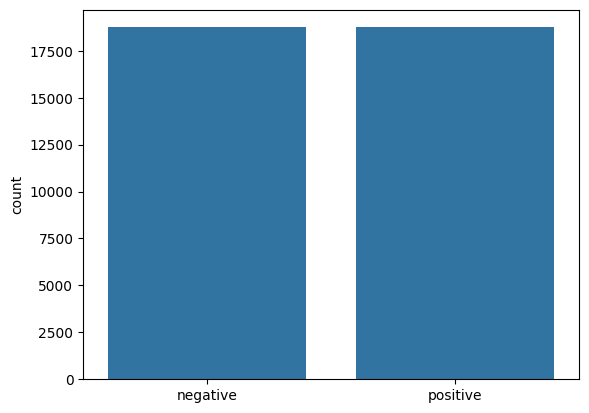

In [16]:
dd=pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd)
plt.show()


In [17]:
def preprocess_strings(s):
  #Remove all non-word characters ( Eveything except numbers and letters)
  s=re.sub(r"[^\w\s]",'',s)
  #Replace all runs of wwhitespaces with no space
  s=re.sub(r"\s+",'',s)
  #Replace digits with no space
  s=re.sub(r"\d",'',s)
  return s

In [28]:
def tokenize(x_train,y_train,x_val,y_val):
  word_list=[]
  stop_words=set(stopwords.words('english'))

  for sent in x_train:
    for word in sent.lower().split():
      word = preprocess_string(word)
      if word not in stop_words and word != '':
        word_list.append(word)

  corpus=Counter(word_list)
  #Sorting on the basis of most common words
  corpus_=sorted(corpus,key=corpus.get,reverse=True)[:1000]
  #Creating a dict
  onehot_dict={w:i+1 for i,w in enumerate(corpus_)}

  #Tokenize
  final_list_train,final_list_test=[],[]
  for sent in x_train:
    final_list_train.append([onehot_dict[preprocess_strings(word)] for word in sent.lower().split() if preprocess_strings(word) in onehot_dict.keys()])

  for sent in x_test:
    final_list_test.append([onehot_dict[preprocess_strings(word)] for word in sent.lower().split() if preprocess_strings(word) in  onehot_dict.keys()])

  encoded_train = [1 if label =='positive' else 0 for label in y_train]
  encoded_test = [1 if label=='positive' else 0 for label in y_val]
  return np.array(final_list_train),np.array(encoded_train),np.array(encoded_train),np.array(final_list_test),np.array(encoded_test),onehot_dict


In [ ]:
x_train,y_train,x_test,y_test,vocab=tokenize(x_train,y_train,x_test,y_test)
